In [1]:
from glob import glob
import os
import pickle

import numpy as np

import cv2

from scipy import signal

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
def plot_images(listA, listB, cmapA=None, cmapB=None):
    """
    This function plots two lists of images (listA and listB) into two columns.
    You can provide a specific color map for each column (binary for example)
    listA and listB are lists of tuples :(image_name, image)
    where image_name is a string 
    and image is an image as a numpy array 
    
    """
    
    if len(listA) != len(listB):
        print("The two list must be same size")
        exit()
    
    fig = plt.figure(figsize=(18,12))
    grid = gridspec.GridSpec(len(listA), 2, wspace=.1, hspace=.3)
    
    for i in range(len(listA)):
        axA = plt.Subplot(fig, grid[2*i])
        axA.imshow(listA[i][1][:, :, ::-1] if cmapA is None else listA[i][1], cmap=cmapA)
        axA.set_title('image {}'.format(listA[i][0]))
        axA.set_xticks([])
        axA.set_yticks([])
        fig.add_subplot(axA)
        
        axB = plt.Subplot(fig, grid[2*i + 1])
        axB.imshow(listB[i][1][:, :, ::-1] if cmapB is None else listB[i][1], cmap=cmapB)
        axB.set_xticks([])
        axB.set_yticks([])
        fig.add_subplot(axB)
        
    plt.show()

In [3]:
# images for testing
dir_testing = 'test_images/*.jpg'
list_files_testing = glob(dir_testing)

output_dir = 'output_images/'

print(list_files_testing)

['test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


In [4]:
# ist of tuple (image_name, img) for test images, where img represents an image as Numpy array
raw_images = []
for file in list_files_testing:
    img = cv2.imread(file)
    image_name = os.path.split(file)[-1]
    raw_images.append((image_name, img))

In [5]:
# Load camera matrix and distortion coefficients
camera_calibration_file = 'camera_cal/camera_calibration.pkl'
with open(camera_calibration_file, mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

# Step 1 : Undistort images (no parameters)

**Apply image correction with `cv2.undistort()`**

In [6]:
undist_images = []
for image_name, img in raw_images:
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite(os.path.join(output_dir,'undistorted_'+image_name), undist)
    undist_images.append((image_name, undist))

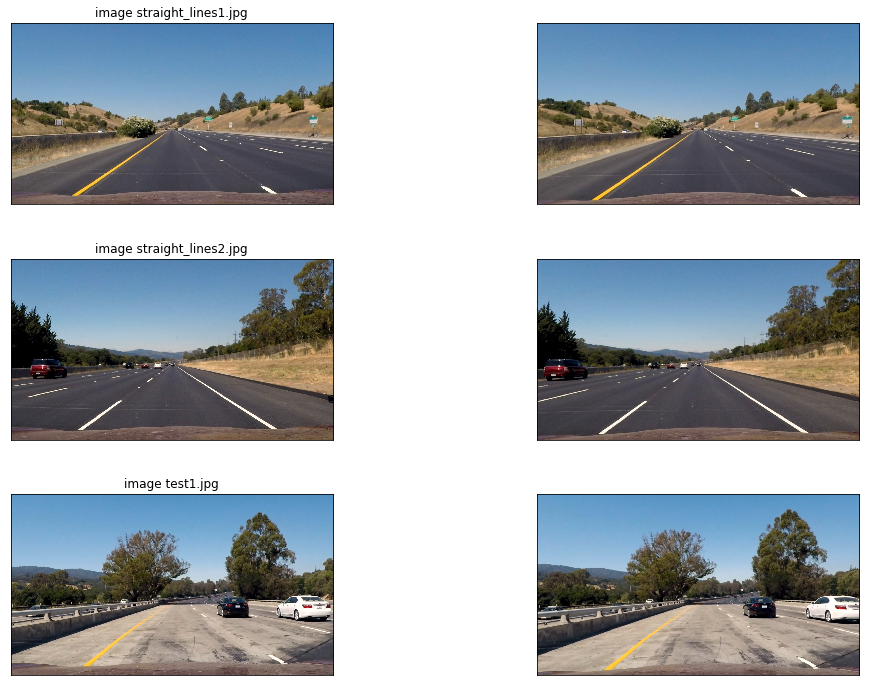

In [7]:
plot_images(raw_images[:3], undist_images[:3])

# Step 2 : Use color and gradient thresholds

- Create a binary image that highlights lane lines

In [8]:
from project.utils import make_binary
help(make_binary)

Help on function make_binary in module project.utils:

make_binary(undist, xgrad_thr=(40, 130), s_thr=(120, 255), l_thr=(45, 255))
    Create a binary image that highlights lane lines
    
    :param undist: undistorted image
    :param xgrad_thr: (min,max) thresholds applied on Sobel operator w.r.t. X axis
    :param s_thr: (min,max) thresholds applied on channel S from HLS colorspace
    :param l_thr: (min,max) thresholds applied on channel L from HLS colorspace
    :return:



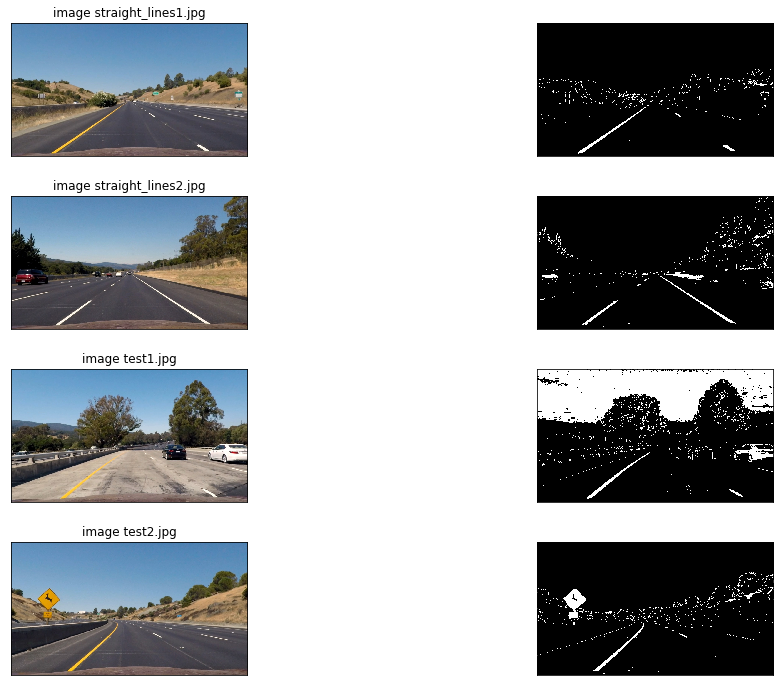

In [9]:
# parameters to tune (then to add in `settings.py`)
xgrad_thr=(40, 130)
s_thr=(120, 255)
l_thr=(45, 255)

binary_images = []
for image_name, undist_image in undist_images:
    binary_image = make_binary(undist_image, xgrad_thr=xgrad_thr,
                               s_thr=s_thr, l_thr=l_thr)
    binary_images.append((image_name, binary_image))
    
plot_images(undist_images[:4], binary_images[:4],cmapB='binary')

# Step 3 : extract Region Of Interest (ROI)

In [10]:
from project.utils import ROI_extraction
help(ROI_extraction)

Help on function ROI_extraction in module project.utils:

ROI_extraction(binary_image, ptA=(560, 450), ptB=(720, 450))
    Apply a mask on ROI region, to select relevant pixels.
    To tune : top points (left and right) that define the region.
    Bottom points are image corners.
    
    This function works well with BGR (or RGB) images and binary images.
    
    :param binary_image: thresholded binary image
    :param ptA: tuple of integers (pixel_h, pixel_w) that define the left top points
    :param ptB: tuple of integers (pixel_h, pixel_w) that define the right top points
    :return: masked image



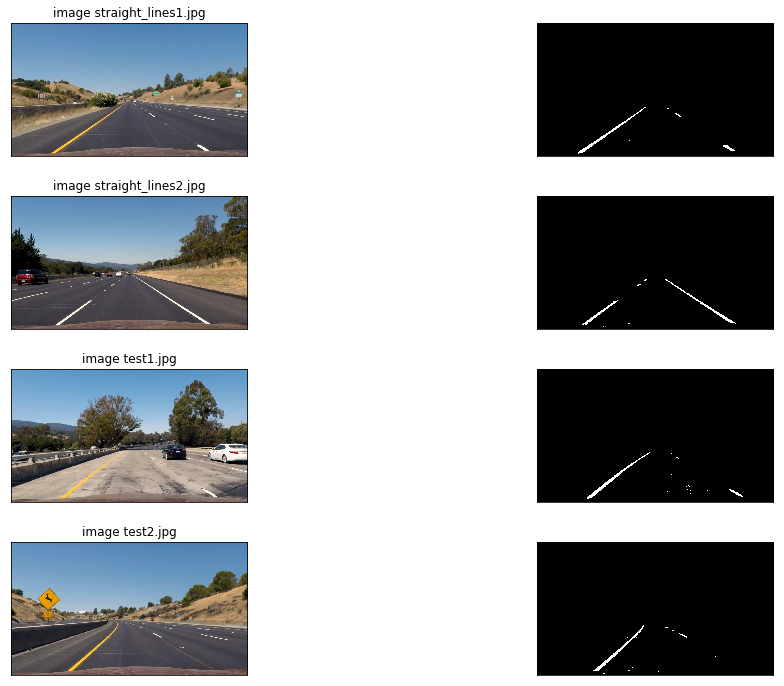

In [18]:
# parameters to tune (then to add in `settings.py`)
ptA=(560, 450)
ptB=(720, 450)

# Apply ROI extraction on undistorted images (useful for parameter selection)
masked_images = []
for image_name, undist_image in undist_images:
    masked_image = ROI_extraction(undist_image, ptA=ptA, ptB=ptB)
    masked_images.append((image_name, masked_image))
#plot_images(undist_images[:4], masked_images[:4])


# Apply ROI extraction on binary images
masked_binary_images = []
for image_name, binary_image in binary_images:
    masked_binary_image = ROI_extraction(binary_image, ptA=ptA, ptB=ptB)
    masked_binary_images.append((image_name, masked_binary_image))
        
plot_images(undist_images[:4], masked_binary_images[:4])

# Step 4 : Get binary lines from 'birds eye view'

In [13]:
from project.utils import get_lines
help(get_lines)

Help on function get_lines in module project.utils:

get_lines(masked_binary_image, corners, offset)
    Apply a perspective transformation to get the lines from a birds eye view.
    
    :param masked_binary_image: binary lines from dashboard view
    :param corners: list of 4 points that define the 'src' for cv2.getPerspectiveTransform
    :param offset: modification applied to corners to define 'dst' for cv2.getPerspectiveTransform
    :return: the warpd image, dst and src (to compute later the inverse perspective transform)



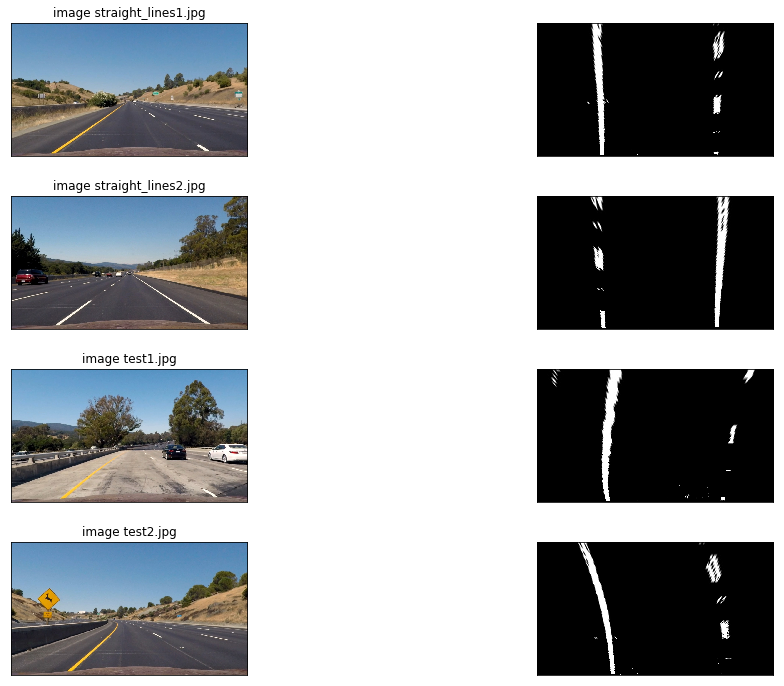

In [14]:
# parameters to tune (then to add in `settings.py`)
corners = np.float32([[190, 720], [589, 457], [698, 457], [1145, 720]])
offset = [150, 0]

warped_binary_images = []
for image_name, masked_binary_image in masked_binary_images:
    warped_binary_image, dst, src = get_lines(masked_binary_image, corners=corners, offset=offset)
    warped_binary_images.append((image_name,warped_binary_image))

plot_images(undist_images[:4], warped_binary_images[:4], cmapB='binary')

# Step 5 : Fit & Draw the Lines 

In [15]:
from project.utils import fit_draw_lines
help(fit_draw_lines)

Help on function fit_draw_lines in module project.utils:

fit_draw_lines(undist_img, binary_lines, dst, src, v_offset=50, h_offset=50, nb_steps=6, window_radius=200)



/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:412: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


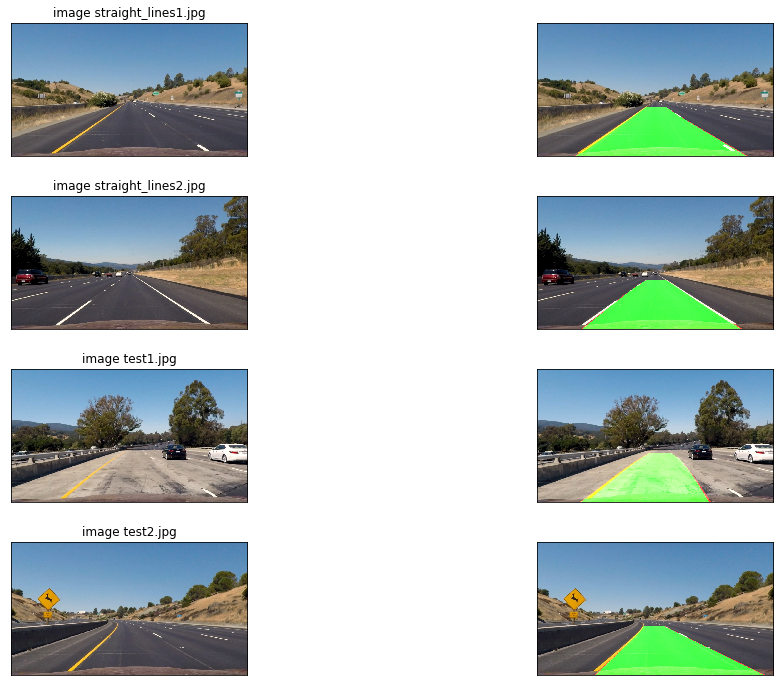

In [21]:
lines_images = []
left_poly = []
right_poly = []
for i in range(len(undist_images)):
    img_lines, left_coeffs, right_coeffs = fit_draw_lines(undist_images[i][1],
                                                          warped_binary_images[i][1][:,:,0],
                                                          dst=dst, src=src)    
    lines_images.append((undist_images[i][0], img_lines))
    right_poly.append(right_coeffs)
    left_poly.append(left_coeffs)

plot_images(undist_images[:4], lines_images[:4])

# Step 6 : compute curvature and display informations

In [27]:
from project.utils import compute_display_curvature
help(compute_display_curvature)

Help on function compute_display_curvature in module project.utils:

compute_display_curvature(img_lines, left_coeffs, right_coeffs)



Left lane curve radius:  37074.8903948 pixels
Right lane curve radius:  2926.20764221 pixels
Left lane curve radius:  2080.20271718 pixels
Right lane curve radius:  57049.7449417 pixels
Left lane curve radius:  2717.28460924 pixels
Right lane curve radius:  1242.10577447 pixels
Left lane curve radius:  3725.15099375 pixels
Right lane curve radius:  7003.5002703 pixels
Left lane curve radius:  3224.29893242 pixels
Right lane curve radius:  165881.965939 pixels
Left lane curve radius:  4507.52184244 pixels
Right lane curve radius:  1408.69218267 pixels
Left lane curve radius:  842.053378524 pixels
Right lane curve radius:  972.247697938 pixels
Left lane curve radius:  3917.11252707 pixels
Right lane curve radius:  782.489571734 pixels


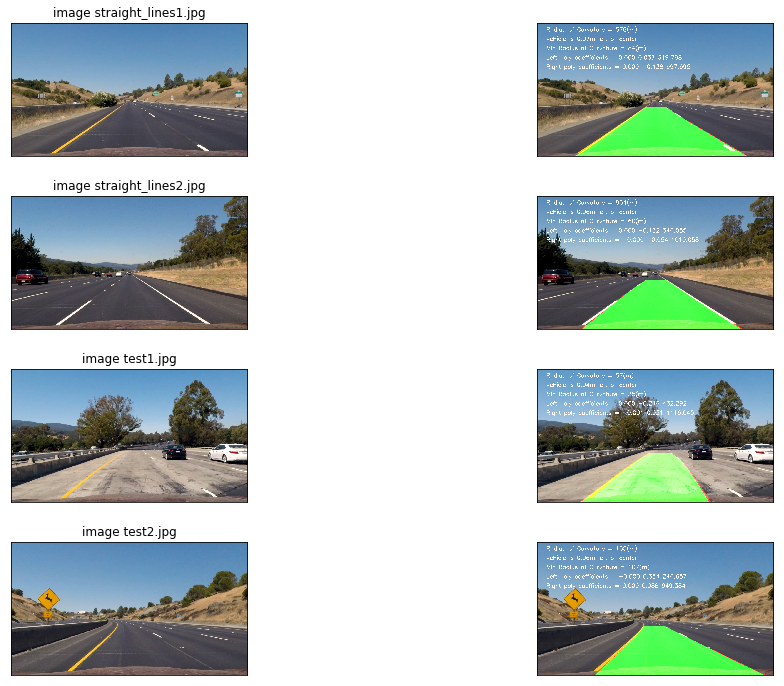

In [28]:
combined_images = []

for i in range(len(undist_images)):
    combined = compute_display_curvature(lines_images[i][1], left_poly[i], right_poly[i])
    combined_images.append((undist_images[i][0], combined))

plot_images(undist_images[:4], combined_images[:4])